Работа с временными рядами.
    
Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from prophet import Prophet
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
from itertools import product

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

RANDOM_STATE = 42

Загрузим данные из датасета, сбросим индекcы и переименуем столбцы, поскольку библиотека, которую будем использовать для предсказания(Prophet) имеет определенные требования к тому, что принимает на вход:

In [2]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
df.reset_index(inplace=True)
df.rename(columns={"Month": "ds", "Accidental deaths in USA: monthly, 1973 ? 1978": "y"}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      72 non-null     datetime64[ns]
 1   y       72 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


Таким образом, можем сделать вывод, что 

In [3]:
df.head()

,ds,y
0,1973-01-01,9007
1,1973-02-01,8106
2,1973-03-01,8928
3,1973-04-01,9137
4,1973-05-01,10017


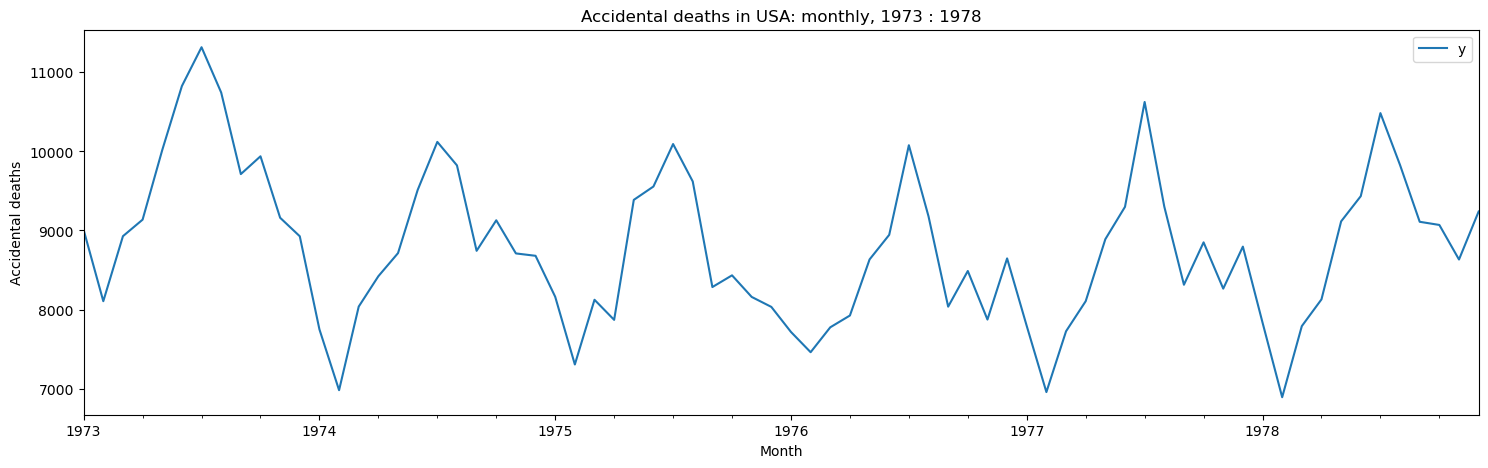

In [4]:
df.plot(x='ds', y='y', title='Accidental deaths in USA: monthly, 1973 : 1978');
plt.ylabel('Accidental deaths');
plt.xlabel('Month');

Для начала определим является является ли наш ряд стационарным. Исходя из графика видим явную сезонность, но чтобы знать точно, применим тест Дики-Фуллера

In [5]:
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(df['y'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))
print('ADF Statistic: %f' % adf_test [0])
print('p-value: %f' % adf_test [1])
if adf_test[1]<0.05:
    print('Time Series is stationary')
else:
    print('Time Series is not stationary')

p-value = 0.1024812205686515
ADF Statistic: -2.555798
p-value: 0.102481
Time Series is not stationary


Т.е. в качестве данных мы имеем нестационарный временной ряд, в котором нет пропусков. 
Будем пытаться делать прогнозы с помощью нескольких моделей, чтобы потом сравнить эффективность каждой из них и с помощью лучшей построить прогноз на следующие два года. 

## Prophet

Поскольку пропусков в данном датасете нету пропусков, разобьем полученный датасет на тренирововчный и тестовый. В данном датасете всего 72 сторки, последние 20 элеметов будем считать тестовой выборкой(как раз около 30% от всего датасета), все остальное будем считать тренировочной выборкой.

In [6]:
prediction_length = 20

train_df = df[:-prediction_length] 
test_df = df.iloc[-prediction_length:]

test_df

,ds,y
52,1977-05-01,8890
53,1977-06-01,9299
54,1977-07-01,10625
55,1977-08-01,9302
56,1977-09-01,8314
57,1977-10-01,8850
58,1977-11-01,8265
59,1977-12-01,8796
60,1978-01-01,7836
61,1978-02-01,6892


Обучаем модель на тренировочной выборке:

In [7]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге dataframe future и 

In [8]:
df_predicted = m.make_future_dataframe(periods=prediction_length, freq='M')

print(df_predicted[-prediction_length:])

forecast = m.predict(df_predicted)

WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



           ds
52 1977-04-30
53 1977-05-31
54 1977-06-30
55 1977-07-31
56 1977-08-31
57 1977-09-30
58 1977-10-31
59 1977-11-30
60 1977-12-31
61 1978-01-31
62 1978-02-28
63 1978-03-31
64 1978-04-30
65 1978-05-31
66 1978-06-30
67 1978-07-31
68 1978-08-31
69 1978-09-30
70 1978-10-31
71 1978-11-30


С помощью методов Prophet.plot и Prophet.plot_components отображаем получившийся прогноз.

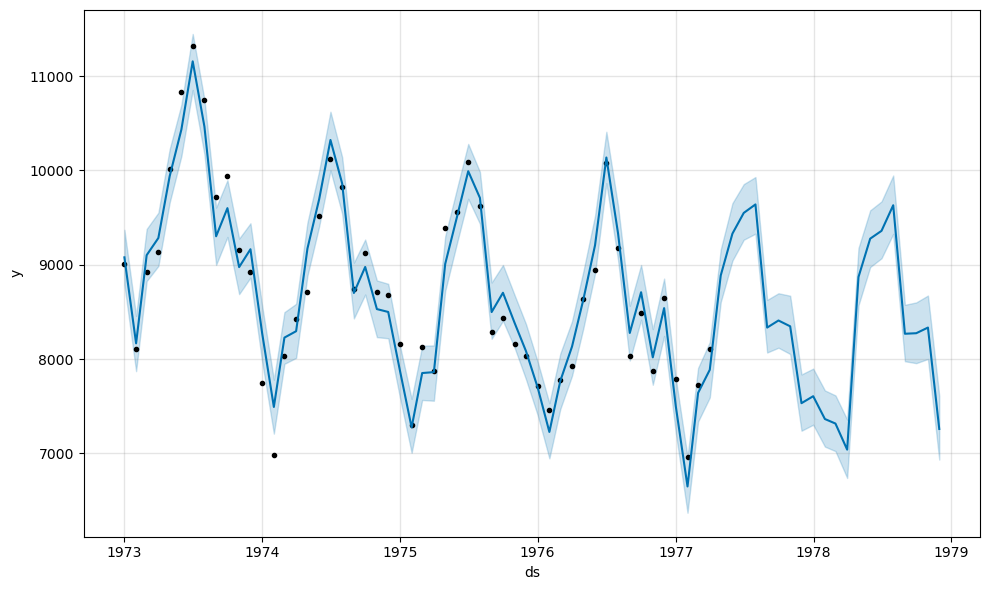

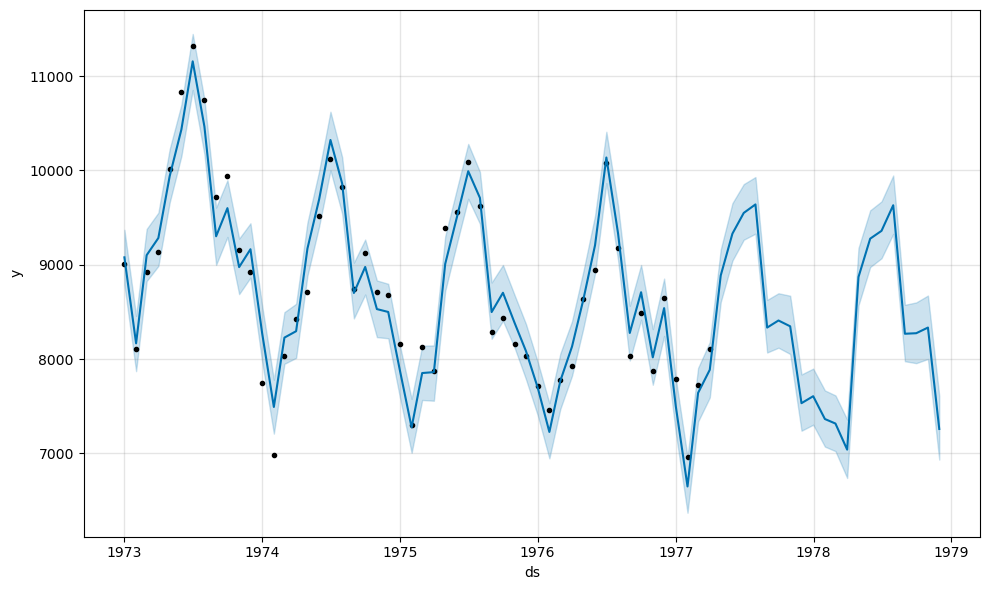

In [9]:
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



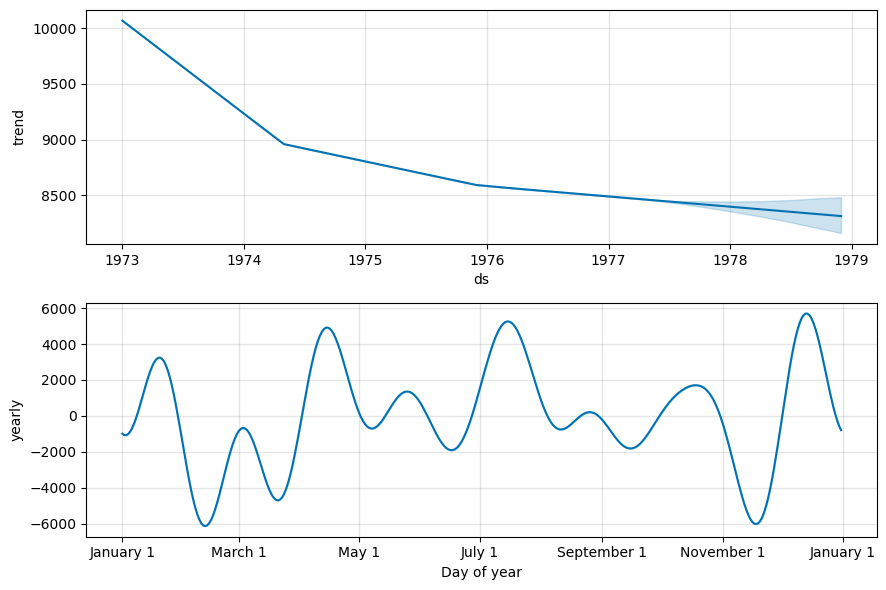

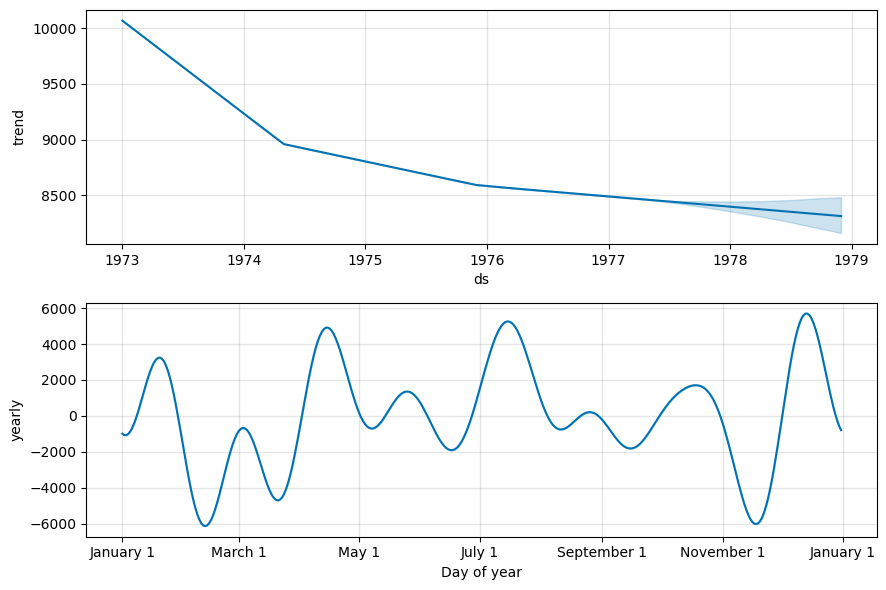

In [10]:
m.plot_components(forecast)

## NeuralProphet

In [11]:
npr = NeuralProphet()
npr.fit(train_df, freq="M") # "M" - месячный интервал

# Cоздание «future dataframe» для получения прогноза на заданное количество месяцев (test_length)
df_np_prediction = npr.make_future_dataframe(train_df, # набор данных для построения прогноза
                                        periods = prediction_length, # количество периодов для построения прогноза
                                        n_historic_predictions=len(train_df) # длина выборки - включаем все исторические данные
                                      )

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.462% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 88.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] 

  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.20E-02, min: 5.85E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.20E-02, min: 5.85E-02


  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.54E-01, min: 2.62E-02
INFO:NP.utils_torch:lr-range-test results: steep: 6.54E-01, min: 2.62E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.28E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.28E-01
Epoch[843/843]: 100%|██████████| 843/843 [00:05<00:00, 167.36it/s, SmoothL1Loss=0.000842, MAE=122, RMSE=154, RegLoss=0]    
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.462% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 88.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Получим прогнох на основании имеющейся модели и визуализируем графики

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

  df = df.append(df_end_to_append)



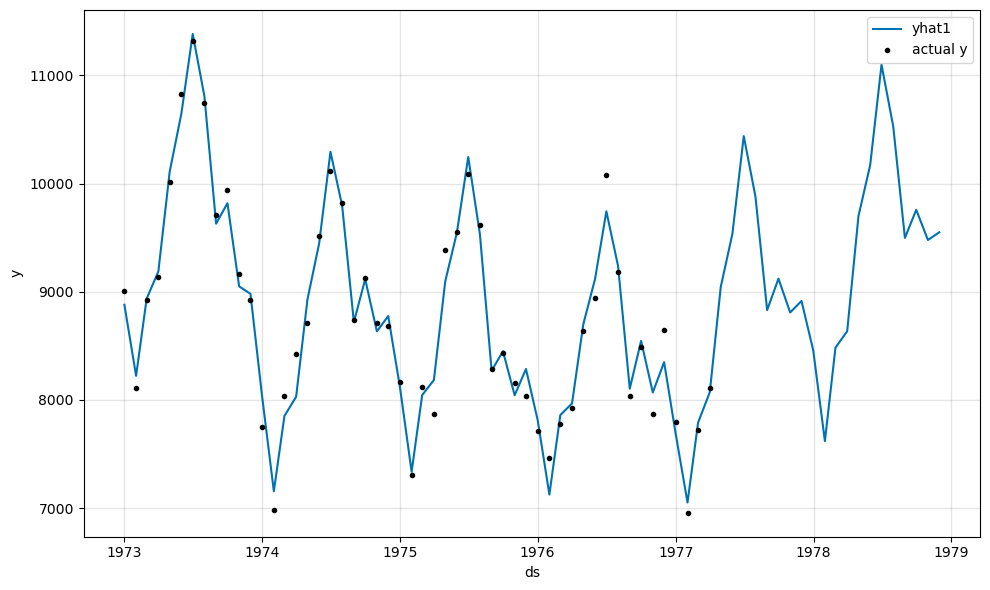

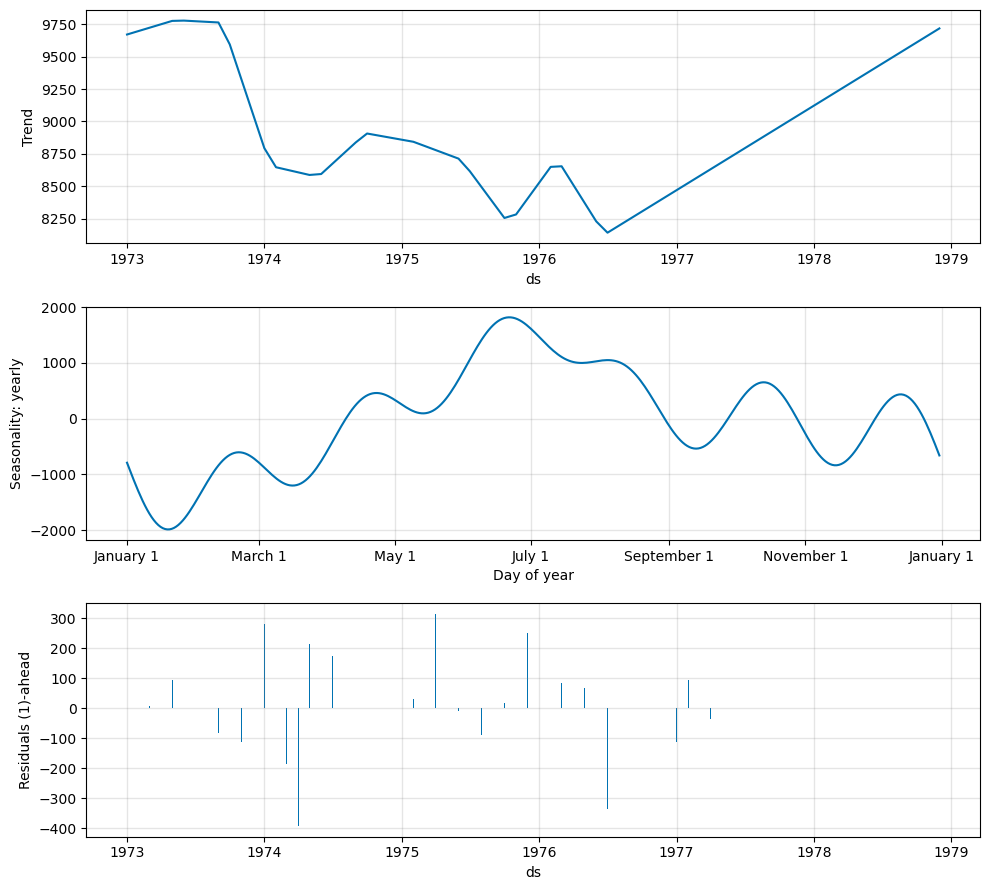

In [12]:
# Получение прогноза
df_np_predict = npr.predict(df_np_prediction)

npr.plot(df_np_predict)
npr.plot_components(df_np_predict, residuals=True);

До этого мы работали с вариациями Prophet. Так же рассмотрим другие модели, с помощью которых можно прогнозировать временной ряд

## SARIMA

Еще в начале мы определили, что рассматриваемый временной ряд не является стационарным. Поскольку у нам наблюдается сезонность, равная 12,проведем сезонное дифференцирование

Критерий Дики-Фуллера: p-value=0.015


<AxesSubplot: >

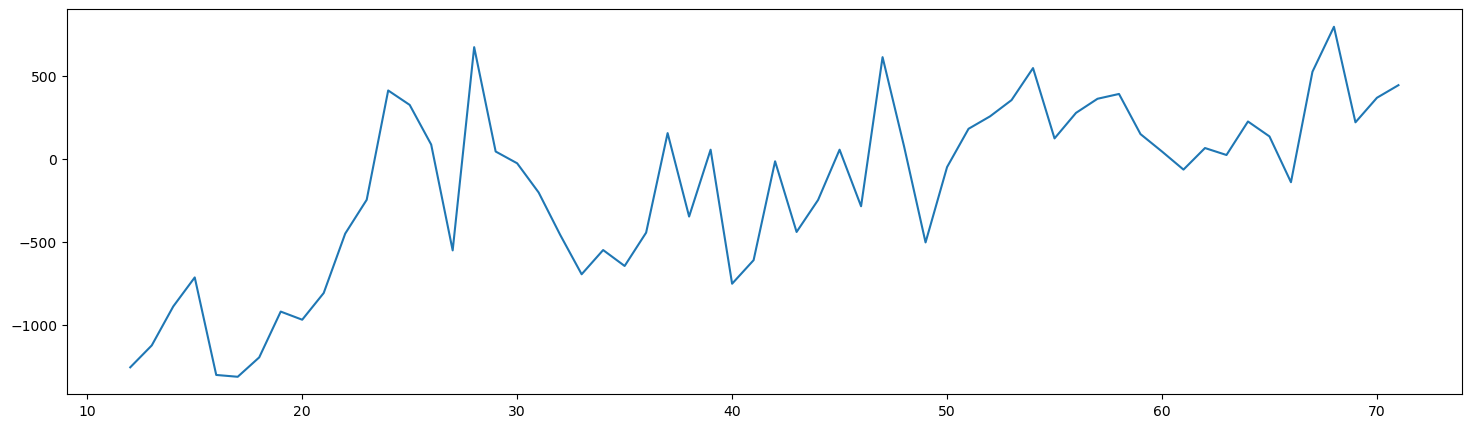

In [13]:
dataset =df.copy(deep = True)

dataset['seasonal_diff'] = dataset.y - dataset.y.shift(12)

p = adfuller(dataset.seasonal_diff[12:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.3f}')

dataset.seasonal_diff[12:].plot()

Дополним дифференцированием

Критерий Дики-Фуллера: p-value=0.000


<AxesSubplot: >

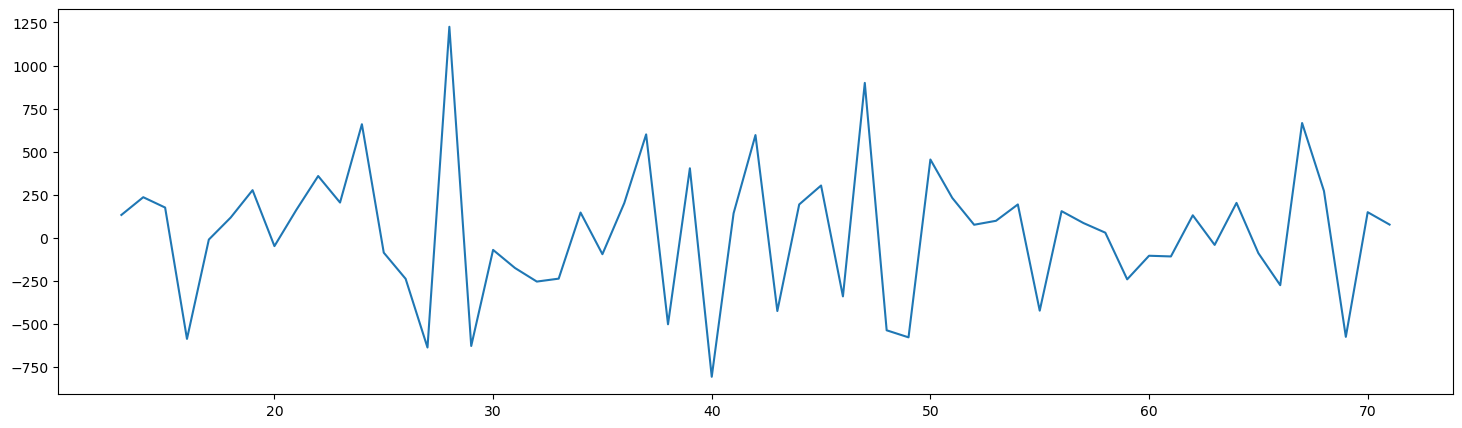

In [14]:
dataset['seasonal_diff_shifted'] = dataset.seasonal_diff - dataset.seasonal_diff.shift(1)

p = adfuller(dataset.seasonal_diff_shifted[13:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.3f}')

dataset.seasonal_diff_shifted[13:].plot()

Теперь наш временной ряд стационарен и можно подбирать парамертры для SARIMAX, где 

p — порядок компоненты авторегрессионной модели

d — порядок интегрированного ряда, в данном случае у нас интегрированный ряд первого порядка, т.е. d = 1

q — порядок компонетны скользящего среднего

Для p и q надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

In [15]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        #Расширенный тест единичного корня Дики-Фуллера.
        #Расширенный тест Дики-Фуллера можно использовать для проверки единичного корня в одномерном процессе при наличии последовательной корреляции.


        plt.tight_layout()
    return 


WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(

  warnings.warn(



Критерий Дики-Фуллера: p=0.000000


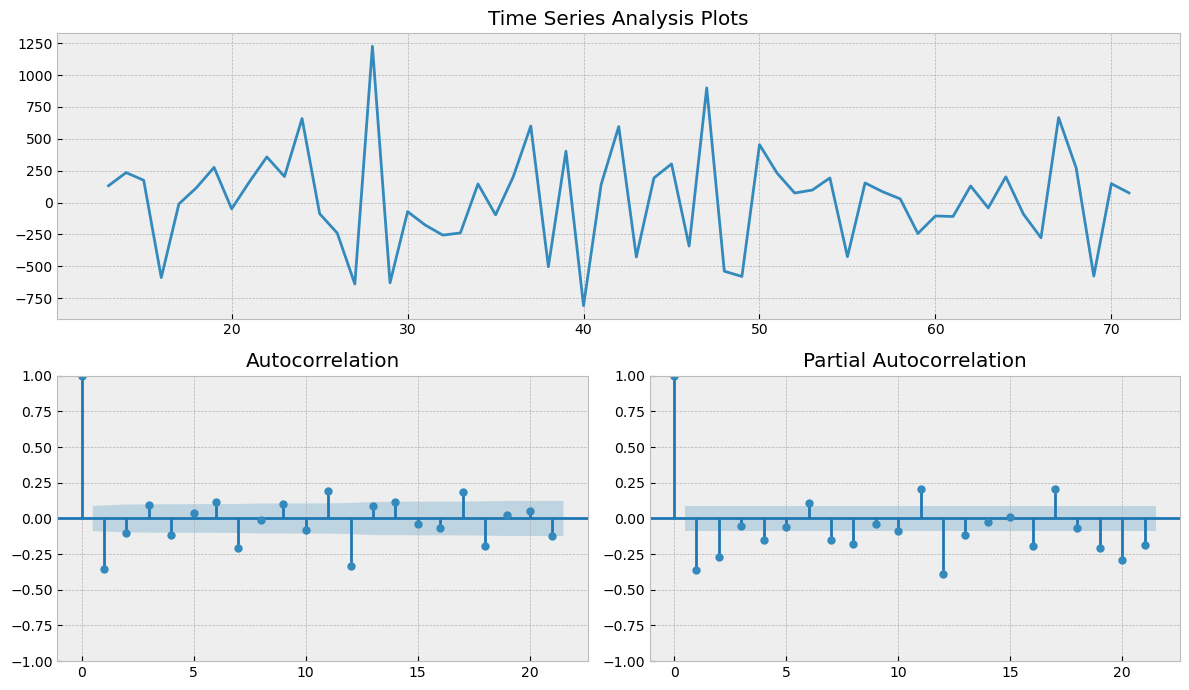

In [16]:
tsplot(dataset.seasonal_diff_shifted[13:], lags=21)

Исходя из ACF и PACF p = 1 и q = 1, тк после этого все данные резко падают. 

Теперь определим сезонные составляющие PDQ, где:

P — порядок сезонной составляющей SAR(P) и в данном слуучае = 1

D — порядок интегрирования сезонной составляющей и в данном случае равно 1

Q — порядок сезонной составляющей SMA(Q) = 12

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -423.523
Date:                            Thu, 05 Jan 2023   AIC                            857.047
Time:                                    17:29:00   BIC                            867.434
Sample:                                         0   HQIC                           861.102
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0950      0.424      0.224      0.823      -0.736       0.926
ma.L1         -0.4711      0.396   

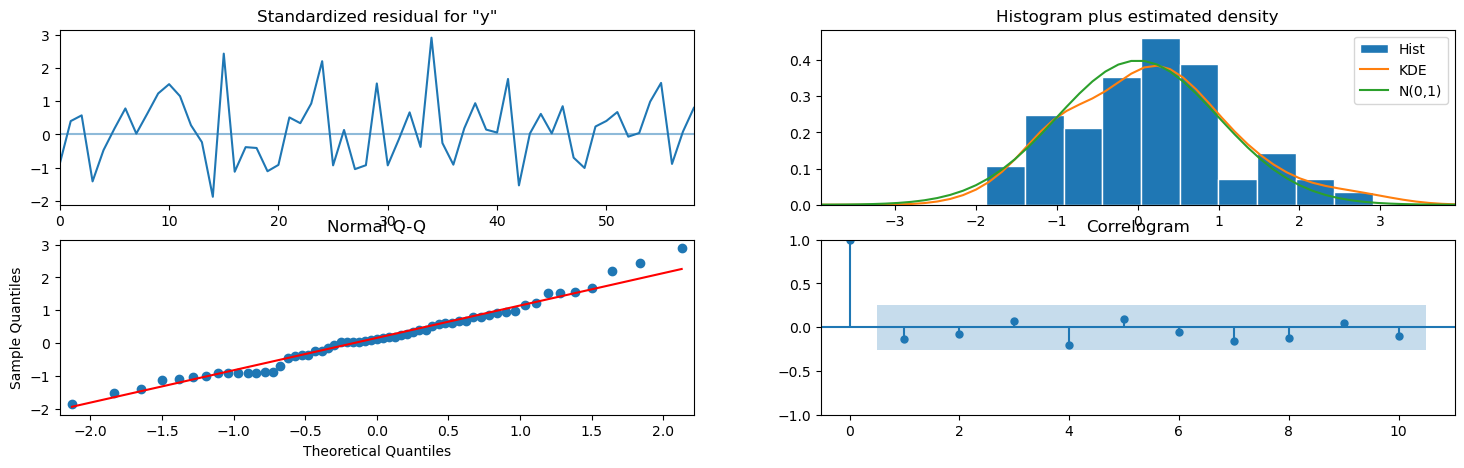

In [17]:
#с учетом этих компонент построим модель:
best_model=sm.tsa.statespace.SARIMAX(dataset['y'], order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12)).fit(disp=-1)

print(best_model.summary())

best_model.plot_diagnostics() #диагностика модели
plt.show()

Имея на руках модели, сравним каждую из них, чтобы найти лучшую

WARNING - (py.warnings._showwarnmsg) - C:\Users\User\AppData\Local\Temp\ipykernel_13852\3187839950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prophet'] = forecast[-prediction_length:]['yhat']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prophet'] = forecast[-prediction_length:]['yhat']

WARNING - (py.warnings._showwarnmsg) - C:\Users\User\AppData\Local\Temp\ipykernel_13852\3187839950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Сравнение значений MSE
Prophet:	574914.3659
NeuralProphet:	297687.7989


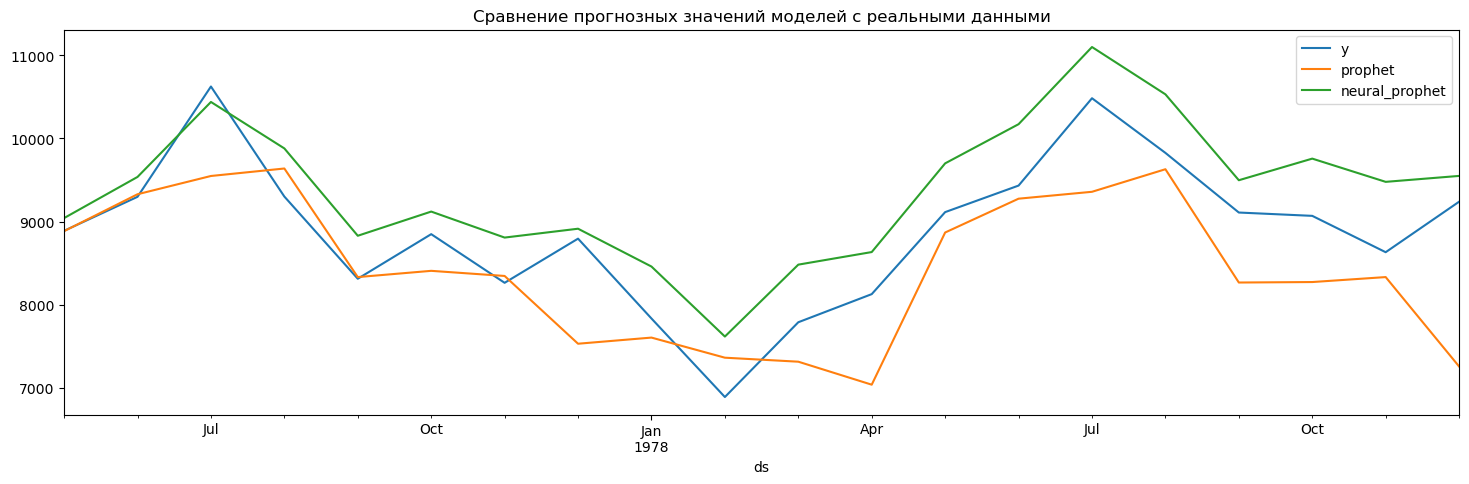

In [18]:
test_df['prophet'] = forecast[-prediction_length:]['yhat']
test_df['neural_prophet'] = df_np_predict[-prediction_length:]['yhat1']
test_df.set_index('ds', inplace=True)

print('Сравнение значений MSE')
print(f"Prophet:\t{mean_squared_error(test_df['y'], forecast[-prediction_length:]['yhat']):.4f}")
print(f"NeuralProphet:\t{mean_squared_error(test_df['y'], df_np_predict[-prediction_length:]['yhat1']):.4f}")

test_df.plot(title='Сравнение прогнозных значений моделей с реальными данными');

Таким образом, наилучшей является NeuralProphet. Построим с ее помощью предсказания на следующие два года: 

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] 

  0%|          | 0/105 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.86E-01, min: 8.38E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.86E-01, min: 8.38E-01


  0%|          | 0/105 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.09E-01, min: 4.61E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.09E-01, min: 4.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.77E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.77E-01
Epoch[668/668]: 100%|██████████| 668/668 [00:04<00:00, 145.66it/s, SmoothL1Loss=0.0013, MAE=153, RMSE=190, RegLoss=0]        
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
WARNING - (py.warnings._showwarnmsg) - D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

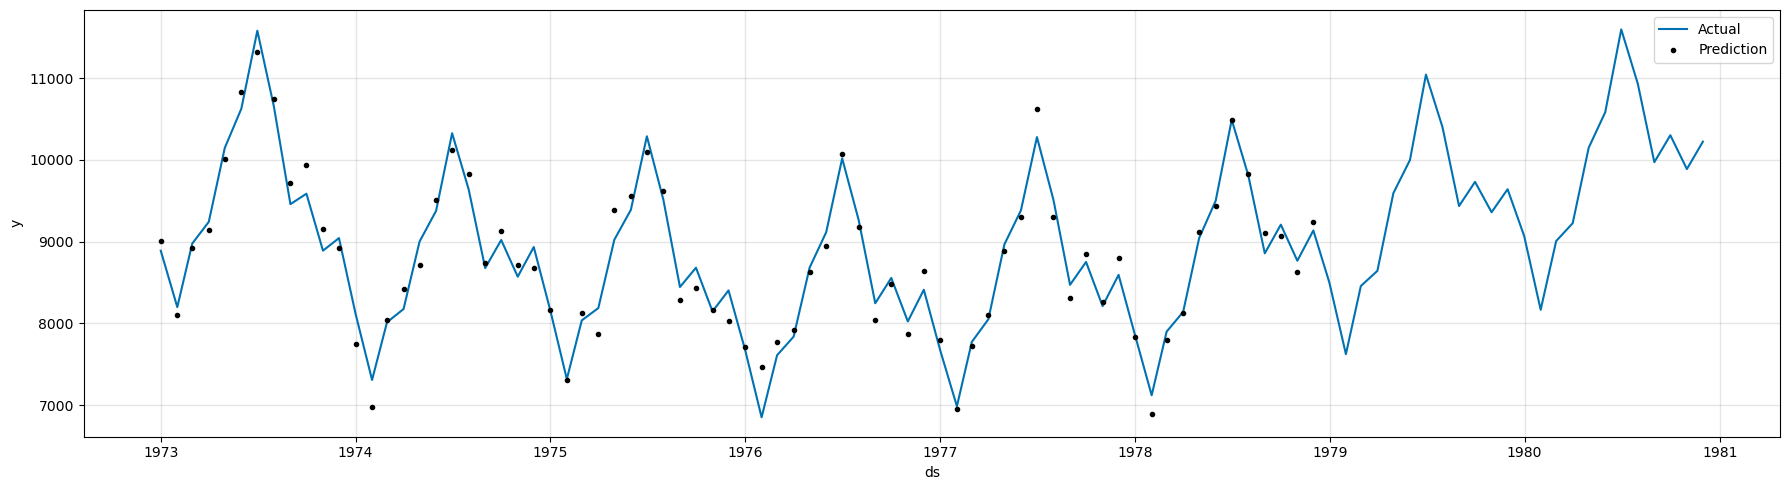

In [19]:
npr = NeuralProphet()
npr.fit(df, freq="M")

df_2_years = npr.make_future_dataframe(df,
                                        periods = 24,
                                        n_historic_predictions=len(df))

# Получение прогноза
df_2_years_predicted = npr.predict(df_2_years)

# Визуалиация «исторических» и прогнозных данных
npr.plot(df_2_years_predicted, figsize=(18,5))
plt.legend(['Actual', 'Prediction'])